In [213]:

from neuron import h
from neuron.units import mV, ms, sec, um, us
from matplotlib import pyplot, cm

h.nrn_load_dll("x86_64/vecevent.so")

#filename = "DATA/Pyrp22.hoc"

#h.load_file(filename)

#h.nrn_load_dll("x86_64/vecevent.so")

ddir = "L5bPCmodelsEH/"

h.load_file("import3d.hoc")
h.load_file("stdgui.hoc")
#h.load_file("stdgui.hoc")
#h.load_file(ddir+"init.hoc")

morphology_file = ddir+"morphologies/cell1.asc"

h.load_file(ddir+"models/L5PCbiophys3.hoc")
h.load_file(ddir+"models/L5PCtemplate.hoc")

h.L5PCtemplate(morphology_file)


L5PCtemplate[7]

In [214]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def PID_tau_tbin(dirsi):
        
    allfiles = os.listdir(dirsi)
    
    files = [i for i in allfiles if "PID_" in i and ".txt" in i]

    files = sorted(files,key= lambda x: (x.split("_")[1],np.int32(x.split("_")[3]),np.int32(x.split("_")[5].split(".")[0])))

    taus = np.unique([np.int32(i.split("_")[3]) for i in files])

    timebins = np.unique([np.int32(i.split("_")[5].split(".")[0]) for i in files])

    Files = []

    for t in taus:

        filest = []

        for tb in timebins:

            fil = []

            for i in files:

                if "_tau_"+str(t)+"_timebin_"+str(tb)+"." in i:

                    fil.append(i)

            filest.append(fil)

        Files.append(filest)
    
    plot = False
    
    PIDtau = []

    for k in range(len(taus)):

        cm = 1./2.54

        PIDbin = []

        for j in range(len(timebins)):

            PIDmatrix = []

            #LabNam = [Files[k][j][i].split("_")[1] for i in range(len(Files[k][j]))]

            #print("tau=",taus[k]," timebin=",timebins[j])

            for i in range(len(Files[k][j])):

                Datos = pd.read_csv(dirsi+"/"+Files[k][j][i],sep=',',header=None)
                
                PIDmatrix.append(Datos.values)

            PIDbin.append(PIDmatrix)

        PIDtau.append(PIDbin)
    
    PIDM = np.array(PIDtau)

    PIDsum = np.sum(PIDM,axis=4)
    
    return PIDsum,timebins,taus,PIDM

def Plot(tbin,tau,PIDsum,Case):

    Soma = [i for i in Labels if "oma" in i]
    Dendric = [i for i in Labels if "oma" not in i]

    #Dendric = [Dendric[i] for i in IndxSort-1]

    fig = plt.figure(figsize=(6*cm,20*cm))

    Dmax = []

    ax1 = fig.add_subplot(311,projection='3d')

    ax2 = fig.add_subplot(312,projection='3d')

    ax3 = fig.add_subplot(313,projection='3d')

    axs = [ax1,ax2,ax3]

    PIDlabel = ["Redundant","Synergistic","Unique"]

    fs = 8

    ll = np.where(abs(timebins-tbin)<1)[0][0]
    tt = np.where(abs(taus-tau)<1)[0][0]

    Dmax = []

    for i in range(3):

        #Dd = np.max(PIDsum[tt,ll,i])

        Dmax.append(np.max(PIDsum[tt,ll,i]))

    for kk in range(len(axs)):

        data = PIDsum[tt,ll,kk,:]#[IndxSort-1]

        idx = np.argsort(data)

        cl = plt.cm.jet(np.linspace(0,np.max(data)/Dmax[kk],len(data)))

        Dendri = [Dendric[i] for i in idx]
        #Dendri = [Dendric[i] for i in range(len(data))]

        # Plot dendritic branches
        ############################.
        for j in range(len(Dendri)):

            i = Dendri[j]

            if len(Morpho[i])>0:
                xp = Morpho[i][:,0]
                zp = Morpho[i][:,1]
                yp = Morpho[i][:,2]

                axs[kk].plot(xp,yp,zp,'-',color=cl[j],linewidth=1)

        #Plot scale and ticks labels 
        ########################
        ps = []

        for j in [0,2,1]:

            pmin = np.min([np.min(Morpho[i][:,j]) for i in Dendri if len(Morpho[i])>1])
            pmax = np.max([np.max(Morpho[i][:,j]) for i in Dendri if len(Morpho[i])>1])

            ps.append([pmin,pmax])

        axs[kk].set_aspect('equal')

        #if scale==True:
        #    from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

        #    scalebar = AnchoredSizeBar(ax.transData, 2e-2, r"200 $\mu$m", 3,frameon=False,pad=5)

        #    ax.add_artist(scalebar)

        axs[kk].set_xticks(np.arange(100*(ps[0][0]//100),100*(ps[0][1]//100)+100,200))
        axs[kk].set_yticks([])
        axs[kk].set_zticks(np.arange(100*(ps[2][0]//100),100*(ps[2][1]//100)+100,200));
        ##############################

        axs[kk].set_xlabel(r"$\mu$m",labelpad=.5,fontsize=fs)
        #axs[kk].set_ylabel(r"$\mu$m",labelpad=1,fontsize=fs)
        axs[kk].set_zlabel(r"$\mu$m",labelpad=15,fontsize=fs)

        #sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=np.min(data), vmax=np.max(data)))
        sm = plt.cm.ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=0, vmax=Dmax[kk]))

        cms = plt.colorbar(sm,ax=axs[kk],fraction=0.03,shrink=0.5,pad=-0.1)

        cms.set_label("Information bits", fontsize=8)

        cms.ax.tick_params(labelsize=fs)

        #axs[kk].set_title(PIDlabel[kk],fontsize=8)
        axs[kk].set_title(PIDlabel[kk],rotation='vertical',va="center",x=0.1,y=0.5,fontsize=fs,fontweight='bold')

        axs[kk].tick_params(labelsize=fs)

    plt.savefig(Case+"_"+str(tbin)+"_"+str(tau)+".png",dpi=400,bbox_inches="tight")
    
    #plt.savefig("images_inputs/"+str(nn)+".png",dpi=400,bbox_inches="tight")

def Plot3D(name,ddir="",inputsIdx=[],loc=[],ax=None,scale=False,SS=1,SSa=0.1,save=False):
    """
    3D plot of the neuron morphology highliting soma and inputs sections. 
    Warning: Needs h define as global object with cell morphology data already loaded in it.
    Params:
        - name: Filename to save the figure
        - inputsIdx: Index of sections receiving the inputs
    """
    
    Sections = [i for i in h.allsec()]
        
    Paths = [np.array(eval("h."+str(Sections[i])).psection()['morphology']['pts3d']) for i in range(len(Sections))]
    
    if ax==None:
        ax = pyplot.figure().add_subplot(projection='3d')
    
    SomaSec = [i for i in range(len(Sections)) if "soma" in str(Sections[i])]
     
    # Plot dendritic branches
    ############################.
    for i in range(0,len(Paths)):

        if len(Paths[i])>0:
            xp = Paths[i][:,0]
            zp = Paths[i][:,1]
            yp = Paths[i][:,2]
    
            ax.plot(xp,yp,zp,'-k',linewidth=0.5)
    
    # Plot soma
    ########################
    for i in SomaSec:
        
        if len(Paths[i])>0:
            ax.plot(Paths[i][:,0],Paths[i][:,2],Paths[i][:,1],'ro',ms=5,label="Soma",alpha=0.25)
        else:
            ax.plot(0.,0.,0.,'ro',ms=5,label="Soma",alpha=0.25)
       
    # Plot synapses positions
    ###########################
    PathsD = [np.array(eval("h."+str(i)).psection()['morphology']['pts3d']) for i in Sections if ("axon" not in str(i))and("soma" not in str(i))]
    
    if len(inputsIdx)>0:

        SynapsePos = Synapse_3Dpos(PathsD,inputsIdx,loc)

        for i in range(len(SynapsePos)):

            if i==0:
                xp = SynapsePos[i][0]
                zp = SynapsePos[i][1]
                yp = SynapsePos[i][2]

                ax.plot(xp,yp,zp,'ob',ms=SS,alpha=SSa,label="Synapses")
            else:
                xp = SynapsePos[i][0]
                zp = SynapsePos[i][1]
                yp = SynapsePos[i][2]

                ax.plot(xp,yp,zp,'ob',ms=SS,alpha=SSa)            
    
    #Plot scale and ticks labels 
    ########################
    ps = []
    
    for j in [0,2,1]:

        pmin = np.min([np.min(Paths[i][:,j]) for i in range(len(Paths)) if len(Paths[i])>1])
        pmax = np.max([np.max(Paths[i][:,j]) for i in range(len(Paths)) if len(Paths[i])>1])

        ps.append([pmin,pmax])

    ax.set_aspect('equal')
    
    if scale==True:
        from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
        
        scalebar = AnchoredSizeBar(ax.transData, 2e-2, r"200 $\mu$m", 3,frameon=False,pad=5)

        ax.add_artist(scalebar)

    ax.set_xticks(np.arange(100*(ps[0][0]//100),100*(ps[0][1]//100)+100,200))
    ax.set_yticks(np.arange(100*(ps[1][0]//100),100*(ps[1][1]//100)+100,200))
    ax.set_zticks(np.arange(100*(ps[2][0]//100),100*(ps[2][1]//100)+100,200));
    ##############################
    
    ax.set_xlabel(r"$\mu$m")
    ax.set_ylabel(r"$\mu$m")
    ax.set_zlabel(r"$\mu$m")
    
    ax.legend(markerscale=2,frameon=False)
    
    if save!=False:
        pyplot.savefig(ddir+"Neuron_"+name+"_pair.png",dpi=500,bbox_inches="tight")

    return ax

def Synapse_3Dpos(PathsD,inputsIdx,loc):
    """
    Compute the position of each synapse in the detailed dendritic branch
    """
    
    SynapsePos = []

    for j in range(len(loc)):
        #To idenfity closes point to loc value
        vec = PathsD[inputsIdx[j]][1:,:-1]-PathsD[inputsIdx[j]][:-1,:-1]
        
        if len(vec)>1:

            ll = []

            l = 0

            ll.append(l)

            for i in np.linalg.norm(vec,axis=1):

                l += i

                ll.append(l)

            #loc distance across the path
            dloc = ll[-1]*loc[j]

            Vidx = np.argsort(np.abs(ll-dloc))[:2]

            #pts3d points between loc point
            V1,V2 = PathsD[inputsIdx[j]][Vidx,:-1]

            #loc parameter
            vn = np.linalg.norm(V2-V1)

            if vn>0:
                t = (dloc-ll[Vidx[0]])/vn
            else:
                t = 0

            #loc vector (3D line equation)
            VX = V1 + (V2-V1)*t

            SynapsePos.append(VX)

        else:
            
            SynapsePos.append(PathsD[inputsIdx[j]][0])
    
    return SynapsePos


In [215]:
#ddir = "DATA/Inputs_regions/"

ddir = "DATA/"

allfiles = os.listdir(ddir)

dirs = [i for i in allfiles if os.path.isdir(ddir) and "_pair_" in i and '.csv'not in i]

fil = [i for i in allfiles if os.path.isdir(ddir) and "_pair_" in i and '.csv' in i]

#dirs = [i for i in allfiles if os.path.isdir(ddir+i) and "background" in i]

#dirs = [i for i in allfiles if os.path.isdir(ddir+i) and "_Both_200000_" in i]

dirs = sorted(dirs,key=lambda x: (x.split("_")[1],x.split("_")[5]))

dirs


['Simulation_pair_PotentialMonit_Both_200000_Cell_Pyr_p1__timebin_1_numinputs_5002_ISInoise_400_avgnumspikes_575.0']

In [216]:
#pd.read_csv(ddir+fil[0]).columns

In [217]:
from scipy.io import loadmat
import pandas as pd

List = pd.read_csv("DATA/Morpho_data_Pyr_p1_.csv")

Morpho = loadmat("DATA/Morpho_Pyr_p1_pts3d.mat")
Labels = List.Labels.values
IndxSort = np.argsort(List.PathLength.values)[1:]


In [218]:
PIDMs = []
PIDS = []

for ni in range(len(dirs)):

    dirsi = ddir+dirs[ni]

    PIDsum,timebins,taus,PIDM = PID_tau_tbin(dirsi)
    
    PIDMs.append(PIDM)
    PIDS.append(PIDsum)

PIDMs = np.array(PIDMs)


In [219]:
PIDMs.shape

(1, 40, 40, 4, 6, 6)

In [220]:
TDMI = np.sum(PIDMs[0],axis=2)

tdmim = np.mean(np.mean(TDMI,axis=-1),axis=-1)

a,b = np.where(tdmim==np.max(tdmim))

taus[a]*timebins[b]

array([40], dtype=int32)

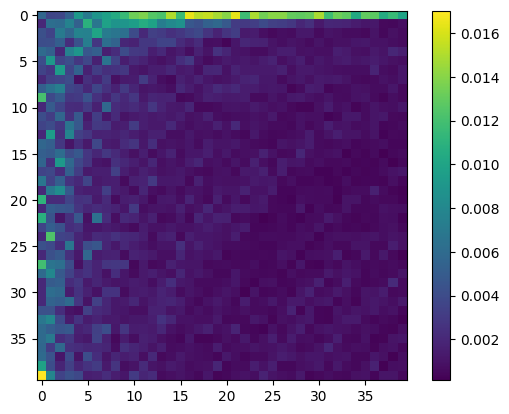

In [221]:

plt.imshow(tdmim)

plt.colorbar()


In [222]:

Red = PIDMs[0,a,b,0].flatten()
Syn = PIDMs[0,a,b,1].flatten()
Un = PIDMs[0,a,b,2].flatten()


In [223]:
listInp = [0,1,29,30,45,46]


In [224]:
data = pd.read_csv("Inputs_info_Both_num_16.csv")

data = data.set_index('InpIndx').iloc[listInp]

Dis = data.Distance.values
Lev = data.Level.values
AvgDia = data.AvgDia.values
Cat = data.Category.values

indx = np.argsort(Dis)

tdmi = TDMI[a,b][0]

xx,yy = np.meshgrid(Dis,Dis)

cm = 1./2.54


In [225]:
Dist = -np.ones([Dis.shape[0],Dis.shape[0],2])
Levs = -np.ones([Lev.shape[0],Dis.shape[0],2])

pid = np.zeros([Dis.shape[0],Dis.shape[0],4])

for i in range(len(Dis)):
    for j in range(len(Dis)):
        if i!=j:        
            Dist[i,j,0] = Dis[i]
            Dist[i,j,1] = Dis[j]
            Levs[i,j,0] = Lev[i]
            Levs[i,j,1] = Lev[j]
            pid[i,j,:] = PIDMs[0,a,b,:,i,j]


In [226]:
Dist = Dist.reshape([Dis.shape[0]*Dis.shape[0],2])
Levs = Levs.reshape([Lev.shape[0]*Lev.shape[0],2])
pid = pid.reshape([Dis.shape[0]*Dis.shape[0],4])


In [227]:
Datos = pd.DataFrame()

Datos["Dis_1"] = Dist[:,0]
Datos["Dis_2"] = Dist[:,1]
Datos["Lev_1"] = Levs[:,0]
Datos["Lev_2"] = Levs[:,1]

Datos["Red"] = pid[:,0]
Datos["Syn"] = pid[:,1]
Datos["Un1"] = pid[:,2]
Datos["Un2"] = pid[:,3]

Datos = Datos[Datos.Dis_1!=-1.]

Datos.shape

(30, 8)

In [228]:
Ddes = Datos.groupby(by=["Dis_1","Dis_2","Lev_1","Lev_2"]).describe()


In [229]:
Ddes = Ddes[Ddes['Red']['count']>1]

In [230]:

#BasBas = Ddes.loc[400.0,200.0].Red['mean']
#BasBasstd = Ddes.loc[400.0,200.0].Red['std']

#Levels = np.array(list(BasBas.index))
#Redm = BasBas.values

#BasBas.plot(yerr=BasBasstd.values,capsize=5,marker='o')


In [231]:
#plt.figure(figsize=(4*cm,4*cm))

#plt.scatter(Levels[:,0],Levels[:,1],c=BasBasstd.values,cmap="jet",marker="s")

#plt.colorbar()


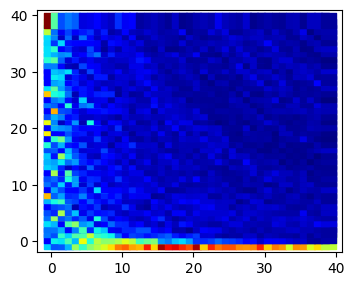

In [234]:

xx,yy = np.meshgrid(timebins,taus)
cm = 1./2.54

plt.figure(figsize=(10*cm,8*cm))

plt.scatter(xx.flatten()-1,yy.flatten()-1,c=tdmim.flatten(),cmap="jet",marker="s",s=110)

#plt.xlim(-0.5,19.5)
#plt.ylim(-0.5,19.5)


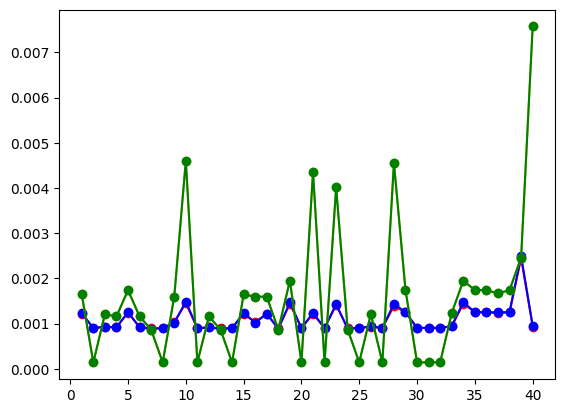

In [238]:
Cosa = PIDMs[ni,:,0,:].reshape([40,4,6*6])

PIDm = np.mean(Cosa,axis=2)
PIDs = np.std(Cosa,axis=2)

cl = ['r','b','y','g']

for i in range(len(cl)):
    
    plt.plot(taus,PIDm[:,i],'-o',color=cl[i])

    #plt.errorbar(taus,PIDm[:,i],yerr=PIDs[:,i],capsize=3,color=cl[i])
    #plt.fill_between(taus,PIDm[:,i]-PIDs[:,i],PIDm[:,i]+PIDs[:,i],color=cl[i],alpha=0.5)

#plt.ylim(0,0.1)
#plt.xlim(1,20)

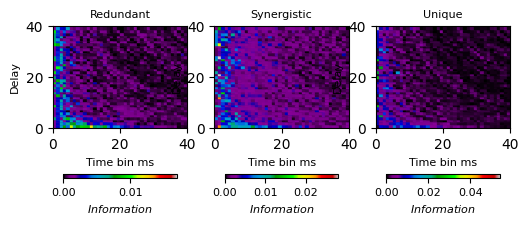

In [241]:
xx,yy = np.meshgrid(timebins,taus)

cm = 1./2.54

fs = 8

Label = ["Redundant","Synergistic","Unique"]

for ni in range(len(dirs)):

    fig,ax = plt.subplots(1,3,figsize=(15*cm,5*cm))

    for i in range(3):

        COSO = np.max(PIDMs[ni,:,:,i].reshape([40,40,6*6]),axis=2)

        ax[i].scatter(xx.flatten(),yy.flatten(),c=COSO.flatten(),cmap="nipy_spectral",marker="s",s=22)

        sm = plt.cm.ScalarMappable(cmap="nipy_spectral", norm=plt.Normalize(vmin=0, vmax=np.max(COSO)))

        cms = plt.colorbar(sm,ax=ax[i],fraction=0.025,orientation="horizontal",shrink=1,pad=0.3,aspect=30)

        cms.set_label(r"$Information$", fontsize=fs)

        cms.ax.tick_params(labelsize=fs)

        ax[i].set_xlabel("Time bin ms",fontsize=fs)
        ax[i].set_ylabel("Delay",fontsize=fs)

        ax[i].set_title(Label[i],fontsize=fs)

        ax[i].set_xlim(0,40)
        ax[i].set_ylim(0,40)

    #plt.savefig("Pairs_"+str(ni)+"_"+dirs[ni].split("_")[2]+"_"+dirs[ni].split("_")[3]+".png",dpi=300,bbox_inches="tight")


In [44]:
PIDMs = []
PIDS = []

for ni in range(1):

    dirsi = ddir+dirs[ni]

    PIDsum,timebins,taus,PIDM = PID_tau_tbin(dirsi)
    
    PIDMs.append(PIDM)
    PIDS.append(PIDsum)
    
PIDMs = np.array(PIDMs)


In [47]:

#ORD = PIDMs[:,:,:,:,IndxSort-1,:][:,:,:,:,:,IndxSort-1]

#ORD.shape


In [ ]:

mpair = np.mean(PIDMs[2,:,:,1,:,:].reshape([20,40,193*193]),axis=2)

a,b = np.where(mpair==np.max(mpair))

a,b,c,d = np.where(PIDMs[2,:,:,2,:,:]==np.max(PIDMs[2,:,:,2,:,:]))

taumax = taus[np.unique(a)]
tbinmax = timebins[np.unique(b)]

print(taumax,tbinmax)


<Axes3D: xlabel='$\\mu$m', ylabel='$\\mu$m', zlabel='$\\mu$m'>

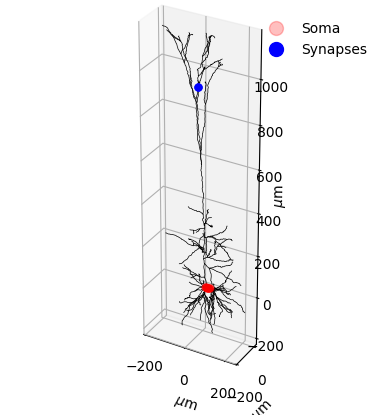

In [8]:
Plot3D("maxsyn",ddir="",inputsIdx=c,loc=[0.5,0.5],SS=5,SSa=1)

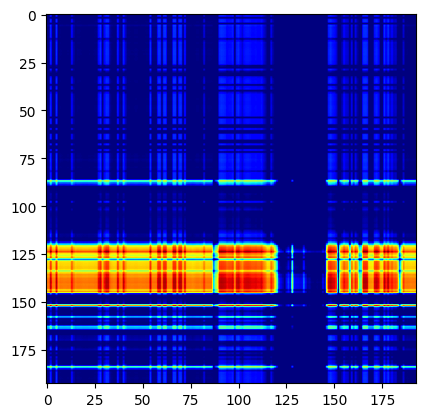

In [9]:
tbinmax = 27
taumax  = 2

RED = PIDMs[2,taumax,tbinmax,0,:,:]
SYN = PIDMs[2,taumax,tbinmax,1,:,:]
UN = PIDMs[2,taumax,tbinmax,2,:,:]

MTDMI = np.sum(PIDMs[2,taumax,tbinmax,:,:,:],axis=0)


MTDMI = MTDMI[IndxSort-1,:][:,IndxSort-1]

#plt.imshow(MTDMI,cmap="jet")

xx, yy = np.meshgrid(timebins,taus)

#plt.contourf(xx,yy,np.sum(ORD[2,:,:,:,-1,5],axis=2),cmap="jet")

mpair = np.mean(ORD[2,:,:,1,:,:].reshape([20,40,193*193]),axis=2)

a,b = np.where(mpair==np.max(mpair))

#timebins[b],taus[a]

plt.imshow(UN,cmap="jet")

[40] [1]
[40] [7]
[37] [9]


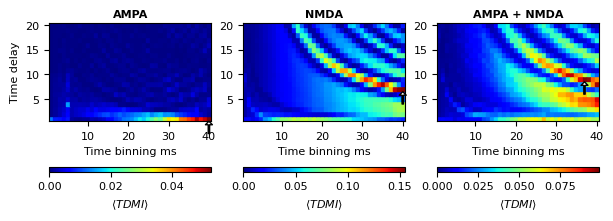

In [21]:

cm = 1./2.54

fig,ax = plt.subplots(1,3,figsize=(18*cm,5*cm))

fs = 8

Cases = {"AMPA":"AMPA","NMDA":"NMDA","Both":"AMPA + NMDA"}

MAXTDMI = []

for ni in range(3):
    
    Case = dirs[ni].split("_")[2]
    Cases[Case]
    TDMI = np.sum(PIDMs[ni],axis=2)
    
    AvgTDMI = np.mean(TDMI,axis=3)
    
    AvgTDMI = np.mean(AvgTDMI,axis=2)
    
    stdTDMI = np.std(TDMI,axis=3)
    
    AvgstdTDMI = np.std(stdTDMI,axis=2)
        
    xx,yy = np.meshgrid(timebins,taus)
    
    Val = AvgTDMI
    #Val = AvgstdTDMI
    
    ax[ni].scatter(xx,yy,c=Val,cmap='jet',marker='s',s=8,vmin=0,vmax=np.max(Val))

    ax[ni].set_xlim(0.5,40.5)
    ax[ni].set_ylim(0.5,20.5)

    ax[ni].set_xlabel("Time binning ms",fontsize=fs)
    
    ax[ni].tick_params(labelsize=fs)

    sm = plt.cm.ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=0, vmax=np.max(Val)))

    cms = plt.colorbar(sm,ax=ax[ni],fraction=0.05,orientation="horizontal",shrink=1,pad=0.3,aspect=30)

    cms.set_label(r"$\left\langle TDMI \right\rangle$", fontsize=fs)
    
    cms.ax.tick_params(labelsize=fs)

    #ax[ni].set_title(Cases[Case],rotation='vertical',va="center",x=-0.35,y=yss[ni],fontsize=fs,fontweight='bold')
    ax[ni].set_title(Cases[Case],va="center",fontsize=fs,fontweight='bold')
    
    if ni!=0:
        ax[ni].tick_params(labelright=False) 
    else:
        ax[ni].set_ylabel("Time delay",fontsize=fs)
   
    
    xa1 = xx[np.where(Val==np.max(Val))]
    ya1 = yy[np.where(Val==np.max(Val))]
    
    MAXTDMI.append((xa1[0],ya1[0]))
    
    print(xa1,ya1)
    
    #ax[ni].scatter(xx[np.where(Val==np.max(Val))],yy[np.where(Val==np.max(Val))],marker="*",color="k",s=50)
    
    ax[ni].annotate('', xy=(xa1, ya1-0.5), xytext=(xa1, ya1-3),
            arrowprops=dict(linewidth=1,edgecolor="black",facecolor='white',width=1,headwidth=5,headlength=2.5),
            )
        
plt.savefig("TDMI_pairSoma_Avg_per_section_pair.png",dpi=300)


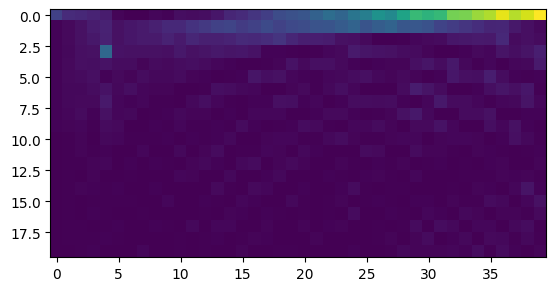

In [22]:
MEAN = np.mean(PIDMs.reshape([3,20,40,3,193*193]),axis=-1)

plt.imshow(MEAN[0,:,:,0])

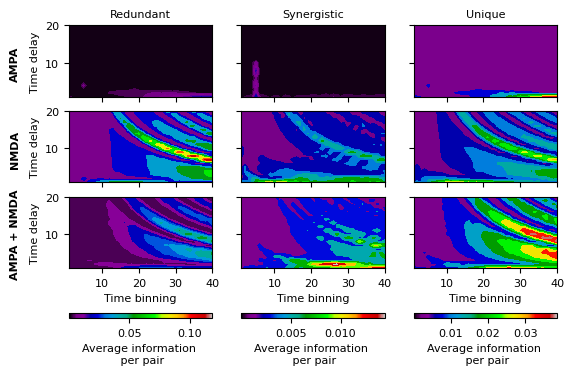

In [23]:
#TOTAL = np.sum(PIDMs[2].reshape([20,40,3,193*193]),axis=3)
    

cm = 1./2.54

fig,ax = plt.subplots(3,3,figsize=(16*cm,10*cm))

PIDlabel = ["Redundant","Synergistic","Unique"]

pc = [None] * 9

for k in range(3):
    
    Case = dirs[k].split("_")[2]
        
    for i in range(3):

        #pc[i+3*k] = ax[k,i].scatter(xx,yy,c=MEAN[k,:,:,i],cmap="jet",marker='s',s=4,alpha=0.8,vmin=np.min(MEAN[:,:,:,i]), vmax=np.max(MEAN[:,:,:,i]))
        pc[i+3*k] = ax[k,i].contourf(xx,yy,MEAN[k,:,:,i],cmap="nipy_spectral",vmin=np.min(MEAN[:,:,:,i]), vmax=np.max(MEAN[:,:,:,i]))

        ax[k,i].tick_params(labelsize=fs)

        if i==0:
            ax[k,i].set_ylabel("Time delay",fontsize=fs)
        
        else:
            ax[k,i].tick_params(labelleft=False)
        
        if k==2:
            ax[k,i].set_xlabel("Time binning",fontsize=fs)
            
            sm = plt.cm.ScalarMappable(cmap="nipy_spectral", norm=plt.Normalize(vmin=np.min(MEAN[:,:,:,i]), vmax=np.max(MEAN[:,:,:,i])))

            cms1 = plt.colorbar(sm,ax=ax[:,i],fraction=0.05,orientation="horizontal",shrink=1,pad=0.15,aspect=30)

            cms1.set_label("Average information \n per pair", fontsize=fs)

            cms1.ax.tick_params(labelsize=fs)

        elif k==0:
            ax[k,i].set_title(PIDlabel[i],fontsize=fs)
            ax[k,i].tick_params(labelbottom=False)  

        else:
        
            ax[k,i].tick_params(labelbottom=False)  
        
        ax[k,i].set_xlim(1,40)
        ax[k,i].set_ylim(1,20)

        if i==0:
            ax[k,i].text(-15,10,Cases[Case],rotation=90,va='center',fontsize=fs,weight='bold')
            
plt.savefig("Average_info_per_pair.png",dpi=300,bbox_inches="tight")


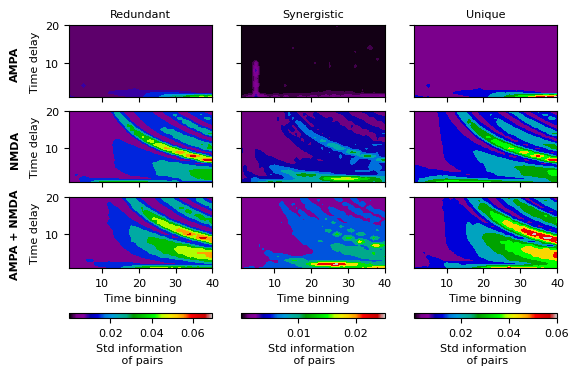

In [24]:

cm = 1./2.54

fig,ax = plt.subplots(3,3,figsize=(16*cm,10*cm))

PIDlabel = ["Redundant","Synergistic","Unique"]

pc = [None] * 9

VAR = np.std(PIDMs.reshape([3,20,40,3,193*193]),axis=-1)

for k in range(3):
    
    Case = dirs[k].split("_")[2]
        
    for i in range(3):

        #pc[i+3*k] = ax[k,i].scatter(xx,yy,c=MEAN[k,:,:,i],cmap="jet",marker='s',s=4,alpha=0.8,vmin=np.min(MEAN[:,:,:,i]), vmax=np.max(MEAN[:,:,:,i]))
        pc[i+3*k] = ax[k,i].contourf(xx,yy,VAR[k,:,:,i],cmap="nipy_spectral",vmin=np.min(VAR[:,:,:,i]), vmax=np.max(VAR[:,:,:,i]))

        ax[k,i].tick_params(labelsize=fs)

        if i==0:
            ax[k,i].set_ylabel("Time delay",fontsize=fs)
        
        else:
            ax[k,i].tick_params(labelleft=False)
        
        if k==2:
            ax[k,i].set_xlabel("Time binning",fontsize=fs)
            
            sm = plt.cm.ScalarMappable(cmap="nipy_spectral", norm=plt.Normalize(vmin=np.min(VAR[:,:,:,i]), vmax=np.max(VAR[:,:,:,i])))

            cms1 = plt.colorbar(sm,ax=ax[:,i],fraction=0.05,orientation="horizontal",shrink=1,pad=0.15,aspect=30)

            cms1.set_label("Std information \n of pairs", fontsize=fs)

            cms1.ax.tick_params(labelsize=fs)

        elif k==0:
            ax[k,i].set_title(PIDlabel[i],fontsize=fs)
            ax[k,i].tick_params(labelbottom=False)  

        else:
        
            ax[k,i].tick_params(labelbottom=False)  
        
        ax[k,i].set_xlim(1,40)
        ax[k,i].set_ylim(1,20)

        if i==0:
            ax[k,i].text(-15,10,Cases[Case],rotation=90,va='center',fontsize=fs,weight='bold')
            
plt.savefig("Var_info_per_pair.png",dpi=300,bbox_inches="tight")


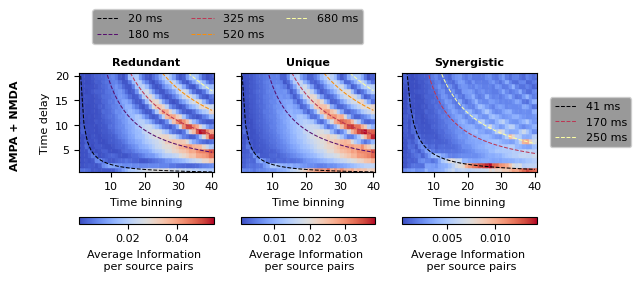

In [25]:
cos = [0,2,1]

cm = 1./2.54

fig,ax = plt.subplots(1,3,figsize=(15*cm,5*cm))

ni = 2

Case = dirs[ni].split("_")[2]
    
for k in range(len(cos)):
    cosa = MEAN[ni,:,:,cos[k]]

    indx = np.where(cosa>=0.05)

    ax[k].scatter(xx,yy,c=cosa,cmap="coolwarm",marker="s",s=15,alpha=0.9)
    
    if k!=2:
        
        ax[k].set_title(PIDlabel[cos[k]],fontsize=fs,fontweight='bold')
        
        if Case=="Both":
            Lines = [20,180,325,520,680]
        elif Case=="NMDA":
            Lines = [10,120,260,400,540,680]    
        else:
            Lines = [30]
            
        cl = plt.cm.inferno(np.linspace(0,1,len(Lines)))

        for i in range(len(Lines)):

            x = np.arange(1,41)

            y = Lines[i]/x

            ax[k].plot(x,y,"--",color=cl[i],lw=0.75,label=str(Lines[i])+" ms")
    
    else:
        
        ax[k].set_title(PIDlabel[cos[k]],fontsize=fs,fontweight='bold')
        
        if Case!="AMPA":
            
            ax[k].set_title(PIDlabel[cos[k]],fontsize=fs,fontweight='bold')

            if Case=="Both":
                Lines = [41,170,250]
            elif Case=="NMDA":
                Lines = [260,41,10]    

            #Lines = [20,41,170,250,325,410,520,600,680]

            cl = plt.cm.inferno(np.linspace(0,1,len(Lines)))

            for i in range(len(Lines)):

                x = np.arange(1,41)

                y = Lines[i]/x

                ax[k].plot(x,y,"--",lw=0.75,color=cl[i],label=str(Lines[i])+" ms")
        
        
    ax[k].set_ylim(0.5,20.5)
    ax[k].set_xlim(0.5,40.5)

    ax[k].tick_params(labelsize=fs)

    ax[k].set_xlabel("Time binning",fontsize=fs)
    
    if k==0:
        ax[k].set_ylabel("Time delay",fontsize=fs)
    else:
        ax[k].tick_params(labelleft=False)
        
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=np.min(cosa), vmax=np.max(cosa)))

    cms = plt.colorbar(sm,ax=ax[k],orientation="horizontal",fraction=0.05,shrink=1,pad=0.3)

    cms.set_label("Average Information \n per source pairs", fontsize=8)

    cms.ax.tick_params(labelsize=fs)
    
    if k==0:
        ax[k].legend(ncol=3,loc=(0.1,1.3),facecolor="gray",fontsize=fs)
    
    elif k==2:
        if Case!="AMPA":
            ax[k].legend(loc=(1.1,0.25),facecolor="gray",fontsize=fs)

ax[0].text(-20,10,Cases[Case],rotation=90,va='center',fontsize=fs,weight='bold')

plt.savefig("Timescales_PID_infor_"+Case+".png",dpi=300,bbox_inches="tight")


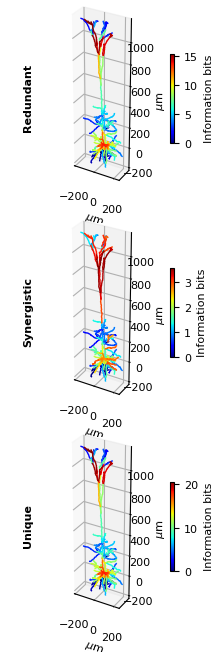

In [41]:

Plot(40,4,PIDS[2],"Both")


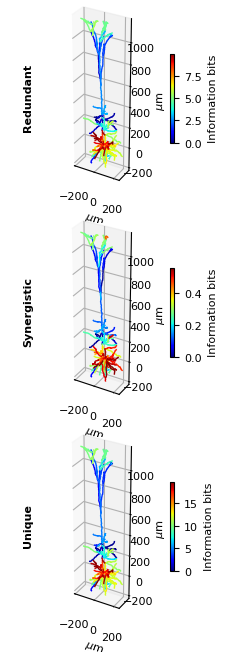

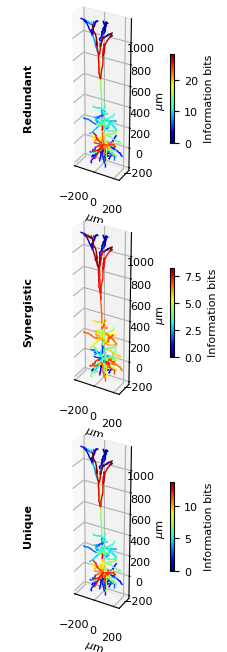

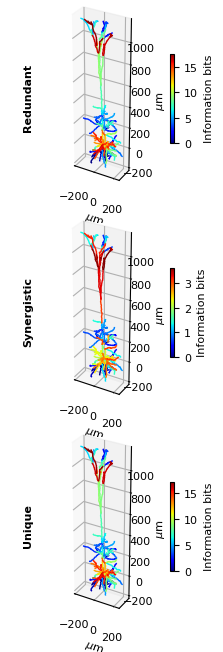

In [42]:
for ni in range(3):

    Case = dirs[ni].split("_")[2]
    
    xa1,ya1 = MAXTDMI[ni]
    
    Plot(xa1,ya1,PIDS[ni],Case)


In [47]:

PIDS = np.array(PIDS)

fi = 2

print(PIDS.shape)

TdmaxPID = []

for p in range(3):
    
    Tdmax = []

    for i in range(PIDS.shape[-1]):

        indx = np.where(PIDS[fi,:,:,p,i]==np.max(PIDS[fi,:,:,p,i]))
        
        #Tdmax.append([(taus[indx[0]]*timebins[indx[1]])[0],(taus[indx[0]]*timebins[indx[1]]+timebins[indx[1]])[0]])
        
        Tdmax.append(timebins[indx[1]][0]*timebins[indx[0]][0])
    
    TdmaxPID.append(Tdmax)

Case = dirs[fi].split("_")[2]

LabCas = Cases[Case]

TdmaxPID = np.array(TdmaxPID)

TdmaxPID.shape



(3, 20, 40, 3, 193)


(3, 193)

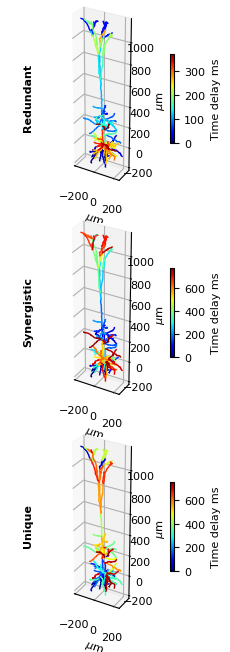

In [48]:
Soma = [i for i in Labels if "oma" in i]
Dendric = [i for i in Labels if "oma" not in i]

fig = plt.figure(figsize=(6*cm,20*cm))

Dmax = []

ax1 = fig.add_subplot(311,projection='3d')

ax2 = fig.add_subplot(312,projection='3d')

ax3 = fig.add_subplot(313,projection='3d')

axs = [ax1,ax2,ax3]

PIDlabel = ["Redundant","Synergistic","Unique"]

Dmax = []

for i in range(3):

    Dd = np.max(TdmaxPID[i])

    Dmax.append(Dd)

for kk in range(len(axs)):

    data = np.array(TdmaxPID[kk,:])
    
    idx = np.argsort(data)
    
    cl = plt.cm.jet(np.linspace(0,np.max(data)/Dmax[kk],len(data)))

    Dendri = [Dendric[i] for i in idx]

    # Plot dendritic branches
    ############################.
    for j in range(len(Dendri)):

        i = Dendri[j]

        if len(Morpho[i])>0:
            xp = Morpho[i][:,0]
            zp = Morpho[i][:,1]
            yp = Morpho[i][:,2]

            axs[kk].plot(xp,yp,zp,'-',color=cl[j],linewidth=1)

    #Plot scale and ticks labels 
    ########################
    ps = []

    for j in [0,2,1]:

        pmin = np.min([np.min(Morpho[i][:,j]) for i in Dendri if len(Morpho[i])>1])
        pmax = np.max([np.max(Morpho[i][:,j]) for i in Dendri if len(Morpho[i])>1])

        ps.append([pmin,pmax])

    axs[kk].set_aspect('equal')

    #if scale==True:
    #    from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

    #    scalebar = AnchoredSizeBar(ax.transData, 2e-2, r"200 $\mu$m", 3,frameon=False,pad=5)

    #    ax.add_artist(scalebar)

    axs[kk].set_xticks(np.arange(100*(ps[0][0]//100),100*(ps[0][1]//100)+100,200))
    axs[kk].set_yticks([])
    axs[kk].set_zticks(np.arange(100*(ps[2][0]//100),100*(ps[2][1]//100)+100,200));
    ##############################

    axs[kk].set_xlabel(r"$\mu$m",labelpad=.5,fontsize=fs)
    #axs[kk].set_ylabel(r"$\mu$m",labelpad=1,fontsize=fs)
    axs[kk].set_zlabel(r"$\mu$m",labelpad=15,fontsize=fs)

    #sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=np.min(data), vmax=np.max(data)))
    sm = plt.cm.ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=0, vmax=Dmax[kk]))

    cms = plt.colorbar(sm,ax=axs[kk],fraction=0.03,shrink=0.5,pad=-0.1)

    cms.set_label("Time delay ms", fontsize=8)

    cms.ax.tick_params(labelsize=fs)

    #axs[kk].set_title(PIDlabel[kk],fontsize=8)
    axs[kk].set_title(PIDlabel[kk],rotation='vertical',va="center",x=0.1,y=0.5,fontsize=fs,fontweight='bold')

    axs[kk].tick_params(labelsize=fs)

plt.savefig("Time_bin_of_Max_Info_"+Case+".png",dpi=300,bbox_inches="tight")


In [12]:
#Simfiles = [i for i in dirs if ".csv" not in i and "background" in i]

Simfiles = [i for i in dirs if ".csv" not in i and "PotentialMonit" in i]

Regions = [i.split("_")[1] for i in Simfiles]
rep = [i.split("_")[6] for i in Simfiles]

#SectionsNames = {}

#for rr in range(len(Regions)):
    
#    SectionsNames[Regions[rr]+"_"+rep[rr]] = list(pd.read_csv(ddir+"/"+Simfiles[rr]+".csv").columns.values)[1:]
    
#SectionsNames

In [161]:

ni = 2

allfiles = os.listdir(ddir+dirs[ni])

#Region = dirs[ni].split("_")[1]

Case = dirs[ni].split("_")[2]

print(Case)

Both


In [162]:

files = [i for i in allfiles if "PID_" in i and ".txt" in i]

files = sorted(files,key= lambda x: (x.split("_")[1],np.int32(x.split("_")[3]),np.int32(x.split("_")[5].split(".")[0])))

taus = np.unique([np.int32(i.split("_")[3]) for i in files])

timebins = np.unique([np.int32(i.split("_")[5].split(".")[0]) for i in files])

Files = []

for t in taus:
    
    filest = []
    
    for tb in timebins:
 
        fil = []

        for i in files:

            if "_tau_"+str(t)+"_timebin_"+str(tb)+"." in i:

                fil.append(i)

        filest.append(fil)
    
    Files.append(filest)


In [3]:

List = pd.read_csv("DATA/Morpho_data_Pyr_p1_.csv")

CellName = List["Cell_name"][0]

IndxSort = np.argsort(List.PathLength.values)[1:]


In [19]:
plot = False
PIDtau = []

for k in range(len(taus)):
 
    cm = 1./2.54
    
    if plot==True:
        fig,ax = plt.subplots(3,len(timebins),figsize=(21*cm,15*cm))
    
    PIDbin = []

    for j in range(len(timebins)):

        PIDmatrix = []

        LabNam = [Files[k][j][i].split("_")[1] for i in range(len(Files[k][j]))]

        #print("tau=",taus[k]," timebin=",timebins[j])

        for i in range(len(Files[k][j])):

            Datos = pd.read_csv(ddir+dirs[ni]+"/"+Files[k][j][i],sep=',',header=None)

            PIDmatrix.append(Datos.values)
            
            if plot==True:
                ax[i,j].imshow(PIDmatrix[i][IndxSort,:][:,IndxSort],cmap='jet',vmin=0,vmax=np.max(PIDmatrix))

                if j==0:

                    ax[i,j].set_ylabel(LabNam[i],fontsize=12)

                if i==0:

                    ax[i,j].set_title("timebin="+str(timebins[j])+" ms",fontsize=8)

                ax[i,j].set_xticks([])
                ax[i,j].set_yticks([])

        PIDbin.append(PIDmatrix)
    
    PIDtau.append(PIDbin)
    
    #plt.savefig("PID_all_sections_tau_"+str(taus[k])+".png",dpi=400,bbox_inches="tight")
    
    if plot==True:
        plt.close()
   

In [20]:
PIDM = np.array(PIDtau)

PIDsum = np.sum(PIDM,axis=4)


In [9]:

nn = 1


In [10]:

path = "images_"+Case+"/"

isExist = os.path.exists(path)

if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(path)


In [55]:
cm = 1./2.54

tt = 0
ll = 0

#for ll in range(len(timebins)-1,-1,-1):
for ll in range(len(timebins)):
    
    Soma = [i for i in Labels if "oma" in i]
    Dendric = [i for i in Labels if "oma" not in i]

    Dendric = [Dendric[i] for i in IndxSort-1]

    fig = plt.figure(figsize=(20*cm,15*cm))

    xx,yy = np.meshgrid(timebins,taus)

    ax01 = fig.add_subplot(234)

    ax02 = fig.add_subplot(235)

    ax03 = fig.add_subplot(236)

    axs0 = [ax01,ax02,ax03]
    
    Dmax = []
    
    for i in range(3):

        Dd = np.max(PIDsum[:,:,i],axis=2)
        
        Dmax.append(np.max(np.max(PIDsum[:,:,i],axis=2)))
        
        pl = axs0[i].scatter(xx-0.5,yy-0.5,c=Dd,cmap="nipy_spectral",marker='s',s=35,vmin=0,vmax=np.max(Dd))

        axs0[i].scatter(timebins[ll],taus[tt],marker="*",c="k",s=75)

        axs0[i].set_xlabel("Timebin")

        if i==0:
            axs0[i].set_ylabel(r"Delay $\tau$")

        from mpl_toolkits.axes_grid1 import make_axes_locatable

        divider = make_axes_locatable(axs0[i])
        cax = divider.append_axes('bottom', size='5%', pad=0.75)

        cms = fig.colorbar(pl, cax=cax, orientation='horizontal')

        cms.set_label("max{Information}", fontsize=10,labelpad=-35)

        #axs0[i].set_title(PIDlabel[i],y=1.3,fontsize=10)

        axs0[i].set_xlim(0,40)
        axs0[i].set_ylim(0,20)
    
    ax1 = fig.add_subplot(231,projection='3d')

    ax2 = fig.add_subplot(232,projection='3d')

    ax3 = fig.add_subplot(233,projection='3d')

    axs = [ax1,ax2,ax3]

    PIDlabel = ["Redundant","Synergistic","Unique"]

    fs = 8

    for kk in range(len(axs)):

        data = PIDsum[tt,ll,kk,:][IndxSort-1]

        idx = np.argsort(data)

        cl = plt.cm.nipy_spectral(np.linspace(0,np.max(data)/Dmax[kk],len(data)))

        Dendri = [Dendric[i] for i in idx]

        # Plot dendritic branches
        ############################.
        for j in range(len(Dendri)):

            i = Dendri[j]

            if len(Morpho[i])>0:
                xp = Morpho[i][:,0]
                zp = Morpho[i][:,1]
                yp = Morpho[i][:,2]

                axs[kk].plot(xp,yp,zp,'-',color=cl[j],linewidth=1)
        
        #Plot scale and ticks labels 
        ########################
        ps = []

        for j in [0,2,1]:

            pmin = np.min([np.min(Morpho[i][:,j]) for i in Dendri if len(Morpho[i])>1])
            pmax = np.max([np.max(Morpho[i][:,j]) for i in Dendri if len(Morpho[i])>1])

            ps.append([pmin,pmax])

        axs[kk].set_aspect('equal')

        #if scale==True:
        #    from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

        #    scalebar = AnchoredSizeBar(ax.transData, 2e-2, r"200 $\mu$m", 3,frameon=False,pad=5)

        #    ax.add_artist(scalebar)

        axs[kk].set_xticks(np.arange(100*(ps[0][0]//100),100*(ps[0][1]//100)+100,200))
        axs[kk].set_yticks([])
        axs[kk].set_zticks(np.arange(100*(ps[2][0]//100),100*(ps[2][1]//100)+100,200));
        ##############################

        axs[kk].set_xlabel(r"$\mu$m",labelpad=.5,fontsize=fs)
        #axs[kk].set_ylabel(r"$\mu$m",labelpad=1,fontsize=fs)
        axs[kk].set_zlabel(r"$\mu$m",labelpad=15,fontsize=fs)

        #sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=np.min(data), vmax=np.max(data)))
        sm = plt.cm.ScalarMappable(cmap="nipy_spectral", norm=plt.Normalize(vmin=0, vmax=Dmax[kk]))

        cms = plt.colorbar(sm,ax=axs[kk],fraction=0.03,shrink=0.5,pad=-0.1)

        cms.set_label("Information bits", fontsize=10)

        axs[kk].set_title(PIDlabel[kk])

        axs[kk].tick_params(labelsize=fs)

    plt.savefig(path+str(nn)+".png",dpi=400,bbox_inches="tight")
    #plt.savefig("images_inputs/"+str(nn)+".png",dpi=400,bbox_inches="tight")
    
    nn += 1
    
    plt.close()


In [75]:
from PIL import Image

image_array = []

files = os.listdir(path)

files = [i for i in files if ".png" in i]

files = sorted(files,key= lambda x: (np.int32(x.split("_")[0].split(".")[0])))


In [76]:
image_list = [Image.open(path+file) for file in files]

# Save the first image as a GIF file
image_list[0].save(
            'PotentialMonit_'+Case+'.gif',
            save_all=True,
            append_images=image_list[:], # append rest of the images
            duration=1000, # in milliseconds
            loop=0)


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D

from matplotlib.text import Annotation

class Annotation3D(Annotation):

    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0, 0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, self.axes.M)
        self.xy = (x2, y2)
        super().draw(renderer)
        
def _annotate3D(ax, text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation = Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D, 'annotate3D', _annotate3D)


In [ ]:
from scipy.io import loadmat
import pandas as pd

List = pd.read_csv("DATA/Morpho_data_Pyr_p1_.csv")

CellName = List["Cell_name"][0]

Morpho = loadmat("DATA/Morpho_Pyr_p1_pts3d.mat")
Labels = List.Labels.values

cm = 1/2.54
fs = 8

fig = plt.figure(figsize=(20*cm,15*cm))

ax1 = fig.add_subplot(111,projection='3d')

Soma = [i for i in Labels if "oma" in i]
Dendric = [i for i in Labels if "oma" not in i]

for i in range(len(Dendric)):

    j = Dendric[i]

    if len(Morpho[j])>0:
        
        xp = Morpho[j][:,0]
        zp = Morpho[j][:,1]
        yp = Morpho[j][:,2]

        ax1.plot(xp,yp,zp,'-',color='k',linewidth=1)

ps = []

for j in [0,2,1]:

    pmin = np.min([np.min(Morpho[i][:,j]) for i in Dendric if len(Morpho[i])>1])
    pmax = np.max([np.max(Morpho[i][:,j]) for i in Dendric if len(Morpho[i])>1])

    ps.append([pmin,pmax])

ax1.set_aspect('equal')

ax1.set_xticks(np.arange(100*(ps[0][0]//100),100*(ps[0][1]//100)+100,200))
ax1.set_yticks([])
ax1.set_zticks(np.arange(100*(ps[2][0]//100),100*(ps[2][1]//100)+100,200));

ax1.set_xlabel(r"$\mu$m",labelpad=.5,fontsize=fs)
#axs[kk].set_ylabel(r"$\mu$m",labelpad=1,fontsize=fs)
ax1.set_zlabel(r"$\mu$m",labelpad=15,fontsize=fs)

ax1.tick_params(labelsize=fs)

Region = "MiddleApical"
rep = "_rep1"

for i in range(len(SectionsNames[Region+rep])):

    Sec = SectionsNames[Region+rep][i]

    xp = Morpho[Sec][-1][0]
    yp = Morpho[Sec][-1][2]
    zp = Morpho[Sec][-1][1]

    ax1.scatter(xp,yp,zp,s=5,c='r')

    ax1.annotate3D('', (xp, yp, zp),
                  xytext=(30, 0),
                  textcoords='offset points',
                  bbox=dict(boxstyle="round", fc="lightyellow"),
                  arrowprops=dict(arrowstyle="-|>", ec='red', fc='white', lw=2))


In [ ]:
PIDSall = []

for ni in range(len(dirs)):

    PIDsum,timebins,taus = PID_tau_tbin(ddir+dirs[ni])
    
    PIDSall.append(PIDsum)

PIDSall = np.array(PIDSall)

RedMax = np.max(PIDSall[:,:,:,0,:].flatten())
SynMax = np.max(PIDSall[:,:,:,1,:].flatten())
UnMax1 = np.max(PIDSall[:,:,:,2,0].flatten())
UnMax2 = np.max(PIDSall[:,:,:,2,1].flatten())

Maxs = [RedMax,SynMax,UnMax1,UnMax2]

Maxss = [RedMax,SynMax,np.max([UnMax1,UnMax2])]


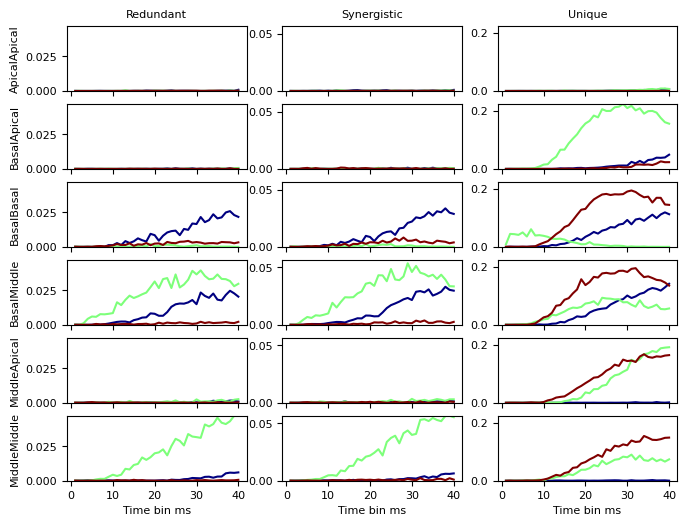

In [17]:

clr = plt.cm.jet(np.linspace(0,1,3))

PIDlabel = ["Redundant","Synergistic","Unique"]

taux = 0

cm = 1./2.54

fig,ax = plt.subplots(6,3,figsize=(20*cm,15*cm))

RegMaxs = []

for jj in range(3):

    Reg = []

    Means = []
    Std = []
    RegLabels = []

    PIDRed = []

    for j in range(6):

        Rep = []

        RegLabels.append(Regions[j*3])

        for i in range(3):

            Rep.append(np.max(PIDSall[j*3+i,:,:,jj],axis=2))

        PIDRed.append(Rep)

        Meanrep = np.mean(Rep,axis=0)
        Stdrep = np.std(Rep,axis=0)

        Reg.append([Meanrep,Stdrep])

        Means.append(Reg[j][0][0,19].flatten())
        Std.append(Reg[j][1][0,19].flatten())
        
    for i in range(6):
        
        RegMaxR = []
        
        for j in range(3):

            Valx = PIDRed[i][j][taux,:]
            
            RegMaxR.append(np.max(Valx))

            ax[i,jj].plot(timebins,Valx,color=clr[j])

            #ax[i,0].plot(timebins,Reg[i][0][taux,:],color=clr[i])

            #ax[i,0].fill_between(timebins,Reg[i][0][taux,:]-Reg[i][1][taux,:],Reg[i][0][taux,:]+Reg[i][1][taux,:],alpha=0.5,color=clr[i])
            
            ax[i,jj].set_ylim(0,Maxss[jj])
            
            ax[i,jj].tick_params(labelsize=8)
            
            if i!=5:
                ax[i,jj].tick_params(labelbottom=False)  
        
        ax[i,0].set_ylabel(RegLabels[i],fontsize=8)
        
        RegMaxs.append(np.max(np.array(RegMaxR)))
        
        if i==0:
            
            ax[i,jj].set_title(PIDlabel[jj],fontsize=8)
            
        if i==5:
            ax[i,jj].set_xlabel("Time bin ms",fontsize=8)

    #MaxSec = np.max(np.array(RegMaxs).reshape(3,6),axis=0)

#for i in range(len(MaxSec)):
    
#    for jj in range(3):
        
#        ax[i,jj].set_ylim(0,MaxSec[i])

plt.savefig("Results_tau_1.png",dpi=300,bbox_inches="tight")


<ErrorbarContainer object of 3 artists>

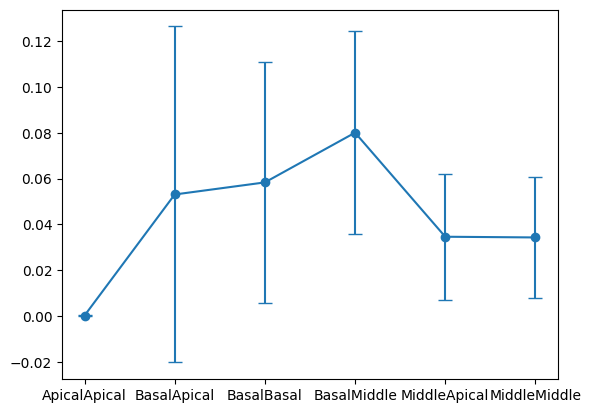

In [18]:
Means = np.array(Means).flatten()
Std = np.array(Std).flatten()

plt.errorbar(RegLabels,Means,Std,capsize=5,marker='o')


In [13]:
DDirs = dirs[:]

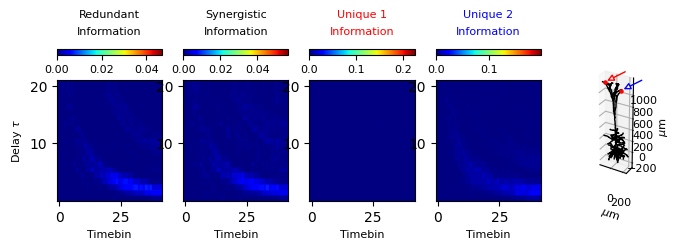

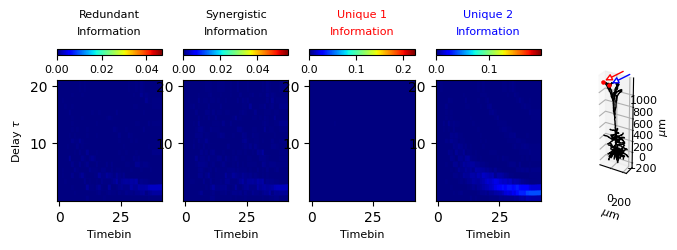

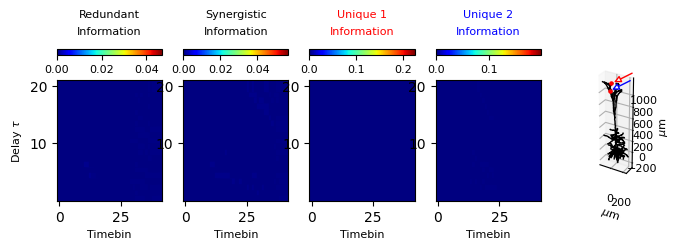

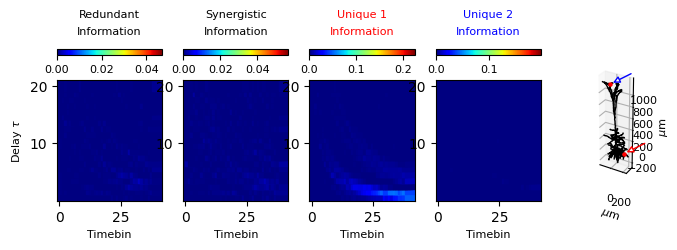

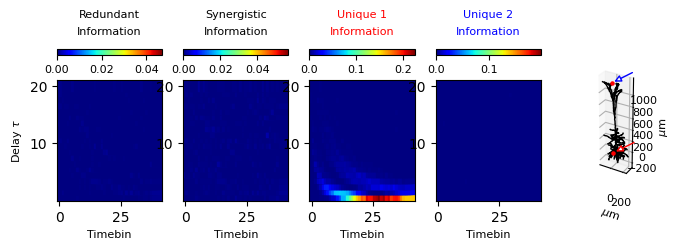

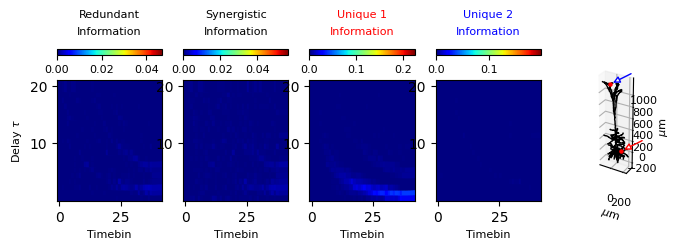

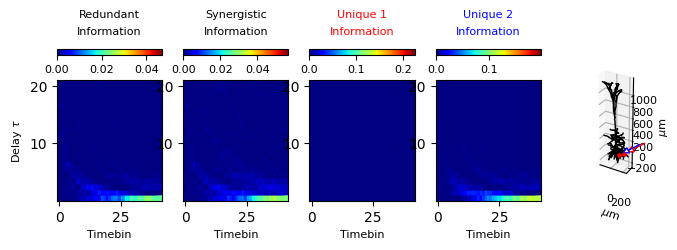

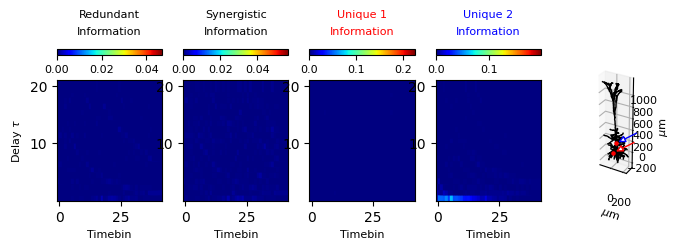

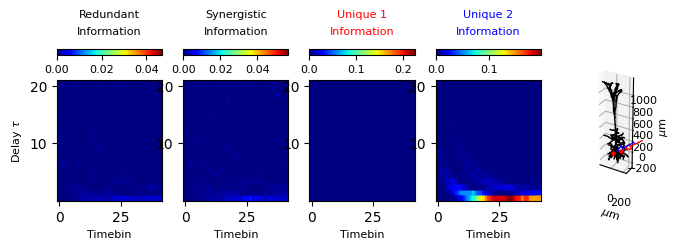

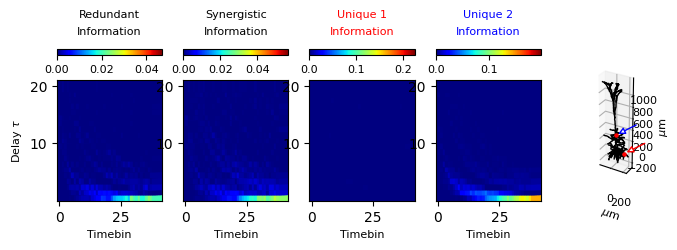

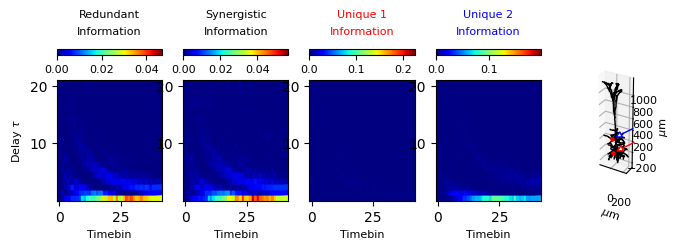

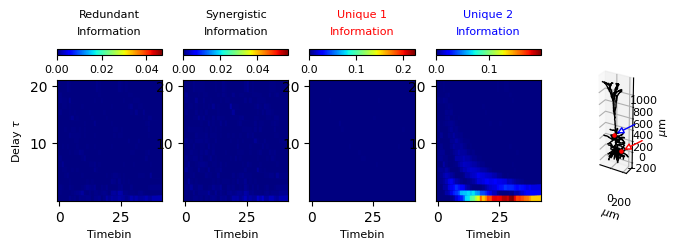

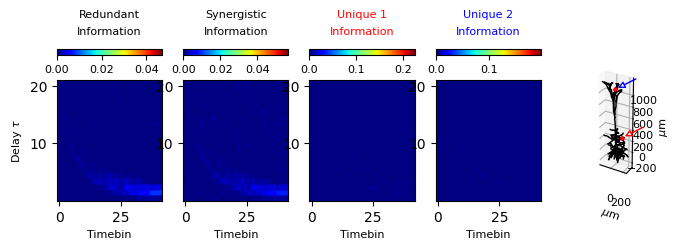

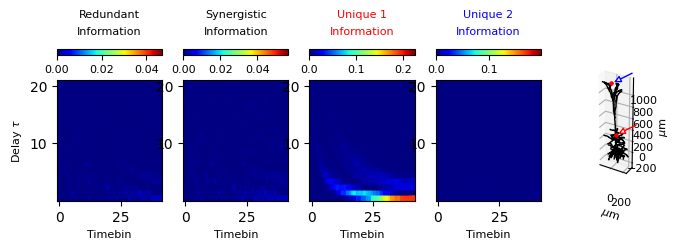

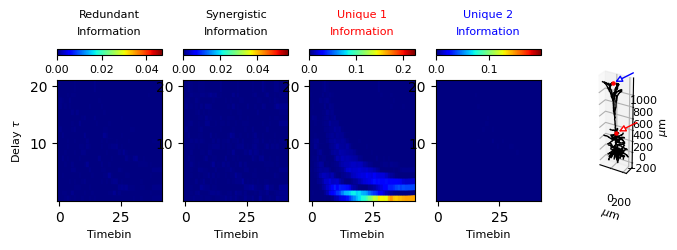

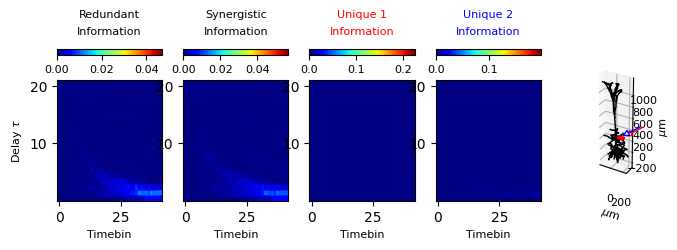

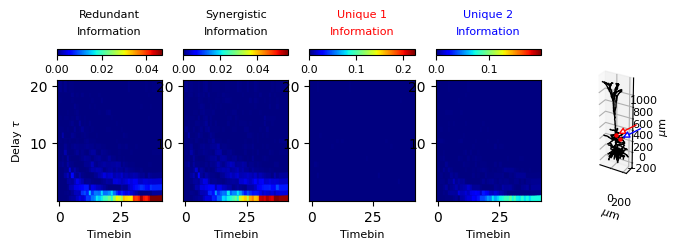

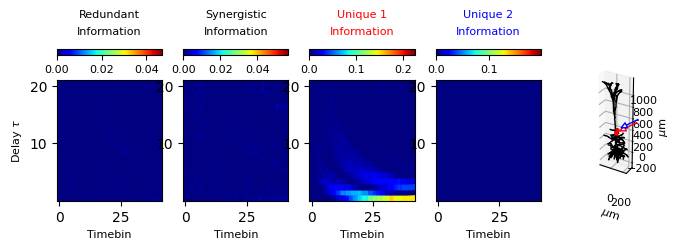

In [14]:

for ni in range(len(DDirs)):

    allfiles = os.listdir(ddir+DDirs[ni])

    Region = DDirs[ni].split("_")[1]
    rep = DDirs[ni].split("_")[5]
    
    PIDsum,timebins,taus = PID_tau_tbin(ddir+DDirs[ni])

    cm = 1/2.54
    
    fs = 8
    
    fig = plt.figure(figsize=(20*cm,5*cm))

    xx,yy = np.meshgrid(timebins,taus)

    ax01 = fig.add_subplot(151)

    ax02 = fig.add_subplot(152)

    ax03 = fig.add_subplot(153)
    ax04 = fig.add_subplot(154)

    ax0 = [ax01,ax02,ax03,ax04]

    PIDlabel = ["Redundant","Synergistic","Unique"]
    
    ecol = ["red","blue"]
    
    for i in range(3):
        
        if i!=2:
            Dd = np.max(PIDsum[:,:,i],axis=2)

            pl = ax0[i].scatter(xx,yy,c=Dd,cmap="jet",marker='s',s=50,vmin=0,vmax=Maxs[i])

            ax0[i].set_xlabel("Timebin",fontsize=fs)

            if i==0:
                ax0[i].set_ylabel(r"Delay $\tau$",fontsize=fs)

            from mpl_toolkits.axes_grid1 import make_axes_locatable

            divider = make_axes_locatable(ax0[i])
            cax = divider.append_axes('top', size='5%', pad=0.25)

            cms = fig.colorbar(pl, cax=cax, orientation='horizontal')

            #cms.set_label("avg{Information}", fontsize=10,labelpad=-35)
            cms.set_label("Information", fontsize=fs,labelpad=-35)

            cms.ax.tick_params(labelsize=fs)

            ax0[i].set_title(PIDlabel[i],y=1.45,fontsize=fs)
            
        else:
            
            U1 = np.round(PIDsum[:,:,i],6)[:,:,0]
            U2 = np.round(PIDsum[:,:,i],6)[:,:,1]
            
            pl = ax0[i].scatter(xx,yy,c=U1,cmap="jet",marker='s',s=50,vmin=0,vmax=Maxs[2])

            ax0[i].set_xlabel("Timebin",fontsize=fs)

            if i==0:
                ax0[i].set_ylabel(r"Delay $\tau$",fontsize=fs)

            from mpl_toolkits.axes_grid1 import make_axes_locatable

            divider = make_axes_locatable(ax0[i])
            cax = divider.append_axes('top', size='5%', pad=0.25)

            cms = fig.colorbar(pl, cax=cax, orientation='horizontal')

            #cms.set_label("avg{Information}", fontsize=10,labelpad=-35)
            cms.set_label("Information",color=ecol[0], fontsize=fs,labelpad=-35)

            cms.ax.tick_params(labelsize=fs)

            ax0[i].set_title("Unique 1",color=ecol[0],y=1.45,fontsize=fs)
            
            pl = ax0[i+1].scatter(xx,yy,c=U2,cmap="jet",marker='s',s=50,vmin=0,vmax=Maxs[3])

            ax0[i+1].set_xlabel("Timebin",fontsize=fs)

            if i==0:
                ax0[i+1].set_ylabel(r"Delay $\tau$",fontsize=fs)

            from mpl_toolkits.axes_grid1 import make_axes_locatable

            divider = make_axes_locatable(ax0[i+1])
            cax = divider.append_axes('top', size='5%', pad=0.25)

            cms = fig.colorbar(pl, cax=cax, orientation='horizontal')

            #cms.set_label("avg{Information}", fontsize=10,labelpad=-35)
            cms.set_label("Information",color=ecol[1], fontsize=fs,labelpad=-35)

            cms.ax.tick_params(labelsize=fs)

            ax0[i+1].set_title("Unique 2",color=ecol[1],y=1.45,fontsize=fs)
            
    ax1 = fig.add_subplot(155,projection='3d')
    
    Soma = [i for i in Labels if "oma" in i]
    Dendric = [i for i in Labels if "oma" not in i]

    for i in range(len(Dendric)):

        j = Dendric[i]

        if len(Morpho[j])>0:

            xp = Morpho[j][:,0]
            zp = Morpho[j][:,1]
            yp = Morpho[j][:,2]

            ax1.plot(xp,yp,zp,'-',color='k',linewidth=1)

    ps = []

    for j in [0,2,1]:

        pmin = np.min([np.min(Morpho[i][:,j]) for i in Dendric if len(Morpho[i])>1])
        pmax = np.max([np.max(Morpho[i][:,j]) for i in Dendric if len(Morpho[i])>1])

        ps.append([pmin,pmax])

    ax1.set_aspect('equal')

    ax1.set_xticks(np.arange(100*(ps[0][0]//100),100*(ps[0][1]//100)+100,200))
    ax1.set_yticks([])
    ax1.set_zticks(np.arange(100*(ps[2][0]//100),100*(ps[2][1]//100)+100,200));

    ax1.set_xlabel(r"$\mu$m",labelpad=.5,fontsize=fs)
    #axs[kk].set_ylabel(r"$\mu$m",labelpad=1,fontsize=fs)
    ax1.set_zlabel(r"$\mu$m",labelpad=15,fontsize=fs)

    ax1.tick_params(labelsize=fs)
    
    for i in range(len(SectionsNames[Region+"_"+rep])):

        Sec = SectionsNames[Region+"_"+rep][i]

        xp = Morpho[Sec][-1][0]
        yp = Morpho[Sec][-1][2]
        zp = Morpho[Sec][-1][1]

        ax1.scatter(xp,yp,zp,s=5,c='r')

        ax1.annotate3D('', (xp, yp, zp),
                      xytext=(20, 10),
                      textcoords='offset points',
                      bbox=dict(boxstyle="round", fc="lightyellow"),
                      arrowprops=dict(arrowstyle="-|>", ec=ecol[i], fc='white', lw=1))

    #plt.savefig("Avg_information_per_inputs_per_section.png",dpi=400,bbox_inches="tight")

    plt.savefig("Information_PID_"+Region+"_"+rep+".png",dpi=400,bbox_inches="tight")


tau= 2  timebin= 20


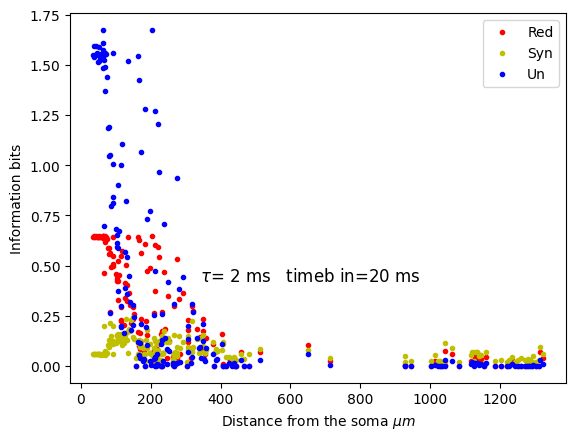

In [21]:
k = 1
j = -1

IndxSort = np.argsort(List[1:].PathLength.values)

PathLength = np.sort(List[1:].PathLength.values)

PIDmatrix = []

LabNam = [Files[k][j][i].split("_")[1] for i in range(len(Files[k][j]))]

print("tau=",taus[k]," timebin=",timebins[j])

for i in range(len(Files[k][j])):

    Datos = pd.read_csv(ddir+dirs[ni]+"/"+Files[k][j][i],sep=',',header=None)

    PIDmatrix.append(Datos.values)

cl = ["r","y","b"]

for i in range(len(Files[k][j])):

    Sx = np.sum(PIDmatrix[i][IndxSort,:][:,IndxSort],axis=1)

    plt.plot(PathLength,Sx,'o',color=cl[i],ms=3,label=LabNam[i])

plt.legend()

plt.xlabel(r"Distance from the soma $\mu m$")
plt.ylabel(r"Information bits")

plt.suptitle(r"$\tau$=%2d ms   timeb in=%2d ms"%(taus[k],timebins[j]),y=0.35)

plt.savefig("PID_vs_distance_inputs_per_sections_tau_"+str(taus[k])+"_timebin_"+str(timebins[j])+".png")


/home/gustavo/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gustavo/.local/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/gustavo/.local/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/gustavo/.local/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


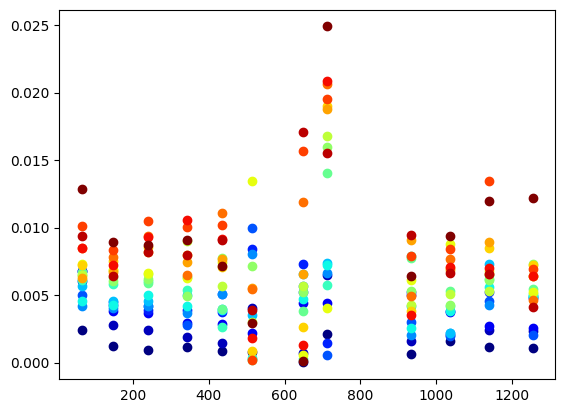

In [28]:

cl = plt.cm.jet(np.linspace(0,1,len(timebins)))

PathLength = List.PathLength.values[IndxSort]


cl = plt.cm.jet(np.linspace(0,1,len(timebins)))

PathLength = List.PathLength.values[IndxSort]

Limits = np.arange(0,1400,100)

for j in range(len(timebins)):
    
    #IM = np.sum(np.sum(PIDM[0,j,:,:,:],axis=0),axis=0)[IndxSort-1]
    
    Ds = np.sum(PIDM[0,j,0,:,:],axis=1)[IndxSort-1]

    for i in range(len(Limits)-1):

        idx = np.where((PathLength>=Limits[i])&(PathLength<Limits[i+1]))

        ddmean = np.mean(PathLength[idx])
        #ddstd = np.std(PathLength[idx])

        
        #IMmean = np.mean(IM[idx])
        #IMstd = np.std(IM[idx])

        Dsmean = np.mean(Ds[idx])
        Dsstd = np.std(Ds[idx])

        #plt.errorbar(ddmean,IMmean,yerr=IMstd,xerr=ddstd,color=cl[j],capsize=5,linestyle="")
        #plt.errorbar(ddmean,Dsmean,yerr=Dsstd,xerr=ddstd,color=cl[j],capsize=5,linestyle="")
        
        plt.plot(ddmean,Dsmean,'-o',color=cl[j])
        
#plt.yscale("log")


tau= 1  timebin= 1


Text(0.5, 0.35, '$\\tau$= 1 ms   timebin= 1 ms')

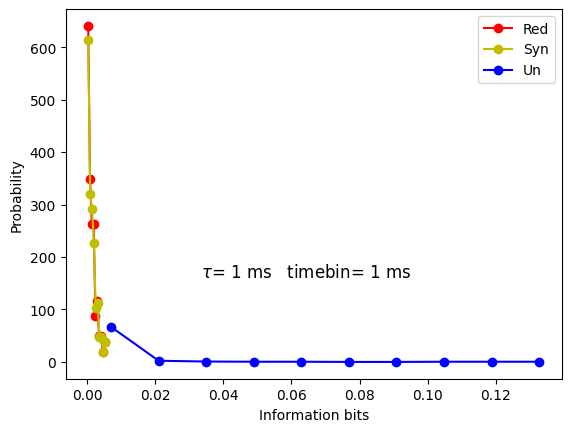

In [32]:
k = 0
j = 0

IndxSort = np.argsort(List[1:].PathLength.values)

PathLength = np.sort(List[1:].PathLength.values)

PIDmatrix = []

LabNam = [Files[k][j][i].split("_")[1] for i in range(len(Files[k][j]))]

print("tau=",taus[k]," timebin=",timebins[j])

for i in range(len(Files[k][j])):

    Datos = pd.read_csv(ddir+dirs[ni]+"/"+Files[k][j][i],sep=',',header=None)

    PIDmatrix.append(Datos.values)

cl = ["r","y","b"]

for i in range(len(Files[k][j])):

    Sx = np.sum(PIDmatrix[i][IndxSort,:][:,IndxSort],axis=1)
    
    p,val = np.histogram(Sx,bins=10,density=True)
    
    vv = 0.5*(val[1:]+val[:-1])
    
    dx = np.mean(val[1:]-val[:-1])
    
    plt.plot(vv,p,'-o',color=cl[i],label=LabNam[i])

plt.legend()

plt.xlabel(r"Information bits")
plt.ylabel(r"Probability")

#plt.xlim(0,8)
#plt.ylim(0,4)

plt.suptitle(r"$\tau$=%2d ms   timebin=%2d ms"%(taus[k],timebins[j]),y=0.35)

#plt.savefig("PID_histo_all_sections_tau_"+str(taus[k])+"_timebin_"+str(timebins[j])+".png")
